# Curriculum Learning

Prototyping curriculum learning for the NextStep-RNN.

- no unrolling
- learning one track at a time
- one time step after another


## Ideen

Unsicherheit prädizieren lassen.
Das könnte man hier leicht einbauen, indem das Netz pro Zeitschritt den MSE prädizieren lässt...

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = './logs/'

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# matplotlib rendering
%matplotlib inline

import sys
sys.path.append("../") # go to parent dir -> for module loading

!{sys.executable} -m pip -q install pandas
!{sys.executable} -m pip -q install sklearn
!apt-get -q install wget

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  wget
0 upgraded, 1 newly installed, 0 to remove and 27 not upgraded.
Need to get 316 kB of archives.
After this operation, 954 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 wget amd64 1.19.4-1ubuntu2.2 [316 kB]
Fetched 316 kB in 0s (1814 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package wget.
(Reading database ... 15402 files and directories currently installed.)
Preparing to unpack .../wget_1.19.4-1ubuntu2.2_amd64.deb ...
Unpacking wget (1.19.4-1ubuntu2.2) ...
Setting up wget (1.19.4-1ubuntu2.

In [4]:
import os
import random
import itertools

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import backend as K
from datetime import datetime
from collections import defaultdict

from IPython.display import clear_output

# custom modules
import data
import model

print('Tensorflow version:', tf.__version__)

print('GPU support:', tf.test.is_gpu_available())
plt.rcParams['figure.figsize'] = [20, 10]

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# set all keras layers to use float
tf.keras.backend.set_floatx('float32')

Tensorflow version: 2.0.0
GPU support: True


In [5]:
# Load the data and unzip quietly
!wget -N https://pollithy.com/Pfeffer.zip
!unzip -q -u Pfeffer.zip

--2019-12-02 11:14:21--  https://pollithy.com/Pfeffer.zip
Resolving pollithy.com (pollithy.com)... 87.118.94.85
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘Pfeffer.zip’ not modified on server. Omitting download.



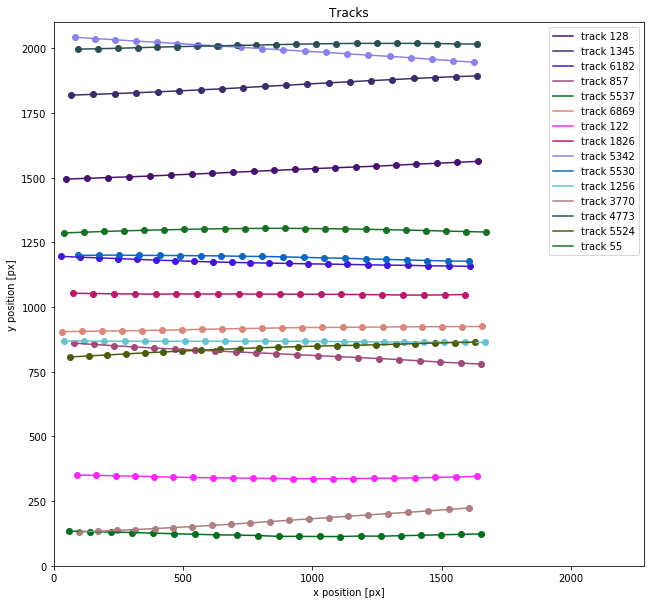

In [17]:
num_time_steps = 35
nan_value = 0
batch_size = 128


csv_data_set = data.CsvDataSet('Pfeffer/trackSortResultPfeffer/*_trackHistory_NothingDeleted.csv',
                               timesteps=num_time_steps, nan_value=nan_value, batch_size=batch_size)

# get tf.Dataset for sequential training
dataset_train, dataset_test = csv_data_set.get_tf_data_sets_seq2seq_data(normalized=True)

csv_data_set.plot_random_tracks(n=15)

In [105]:
# Experimental model which also gets it own prediction of the 
#  last time step and the difference between the last prediction and the last measurement

# input dimensions: [batch_size, 1, len(x, y, old_pred_x, old_pred_y, diff_x, diff_y)]
#  -> e.g. [128, 1, 6]

rnn_model = tf.keras.Sequential()

rnn_model.add(tf.keras.layers.Masking(mask_value=nan_value, name="masking_layer",
                                      batch_input_shape=(batch_size, 1, 6)))

rnn_model.add(tf.keras.layers.LSTM(64, return_sequences=True, stateful=True, unroll=False))
rnn_model.add(tf.keras.layers.Dense(3))

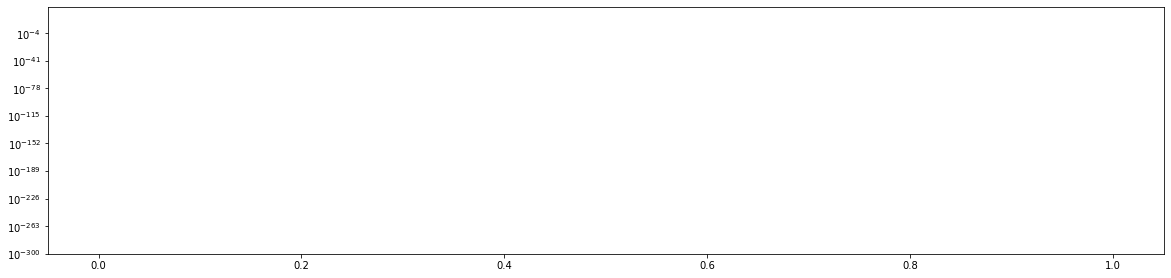

In [106]:
optimizer = tf.keras.optimizers.Adam()

history = []

mask_value = K.variable(np.array([nan_value, nan_value]), dtype=tf.float64)

# for every epoch
for epoch in range(400):

    batch_loss_history = []
    print("epoch: {}".format(epoch))

    # for every batch
    for (batch_n, (inp_batch, target_batch)) in enumerate(dataset_train):
        print(".", end="")
        inp_batch = inp_batch.numpy()
        target_batch = target_batch.numpy()

        sum_batch_loss = 0
        batch_n_time_steps = 0

        _ = rnn_model.reset_states()
        
        # learning rate decay
        if (epoch+1) % 100 == 0:
            old_lr = K.get_value(optimizer.lr)
            new_lr = old_lr * 0.1
            K.set_value(optimizer.lr, new_lr)

        # Calculate the mask
        mask = K.all(K.equal(target_batch, mask_value), axis=-1)
        mask = 1 - K.cast(mask, tf.float32)
        mask = K.cast(mask, tf.float32)

        # for every time step
        for time_i in range(inp_batch.shape[1]):
            with tf.GradientTape() as tape:
                input_ = inp_batch[:, time_i, :].reshape([batch_size, 1, 2])
                target = target_batch[:, time_i, :].reshape([batch_size, 1, 2])
                time_step_mask = tf.reshape(mask[:, time_i], [batch_size, 1])

                if K.sum(time_step_mask) == 0:
                    # if no track of the batch has input data, then we continue with the
                    #   next batch
                    break;

                if time_i == 0:
                    prior_error = tf.zeros_like(input_)
                    prior_prediction = input_

                concat_input = tf.concat((input_, prior_prediction, prior_error), axis=-1)
                concat_input = tf.reshape(concat_input, [batch_size, 1, 6])

                predic = rnn_model(concat_input)

                pos_pred = predic[:, :, :2]
                mse_pred = predic[:, :, 2]

                pos_loss = tf.reduce_sum((csv_data_set.belt_width*(pos_pred - target))**2, axis=-1)**0.5
                mse_loss = (csv_data_set.belt_width*(mse_pred - pos_loss)**2)**0.5
                sum_loss = time_step_mask * (pos_loss + mse_loss)

                sum_batch_loss += K.sum(sum_loss)
                batch_n_time_steps += K.sum(time_step_mask)

                loss = K.sum(sum_loss) / K.sum(time_step_mask)

                prior_error = pos_pred - target
                prior_prediction = pos_pred

                grads = tape.gradient(loss, rnn_model.trainable_variables)
                optimizer.apply_gradients(zip(grads, rnn_model.trainable_variables))

        if batch_n_time_steps > 0:
            batch_loss_history.append((sum_batch_loss/batch_n_time_steps).numpy())
        
    

    
    np_batch_loss_history = np.array(batch_loss_history).reshape([-1])
    mean = np.mean(np_batch_loss_history)
    history.append(mean)

    clear_output(wait=True)
    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    ax.set_yscale('log')
    plt.plot(batch_loss_history)
    plt.show()

(128, 23, 2)


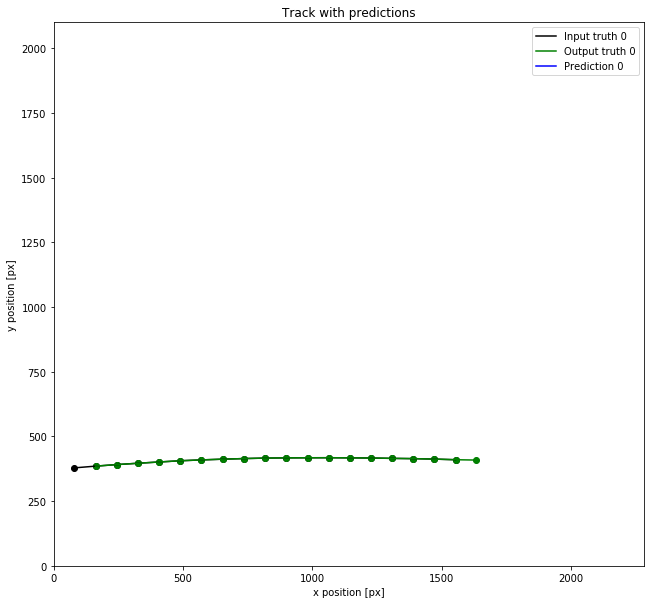

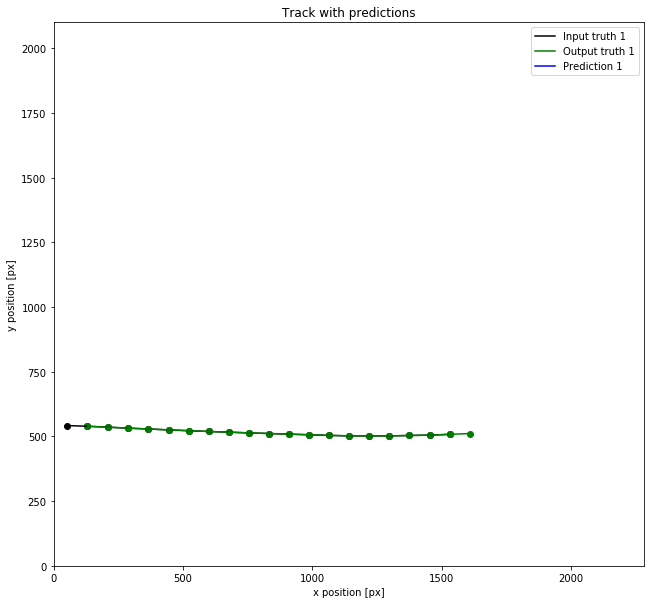

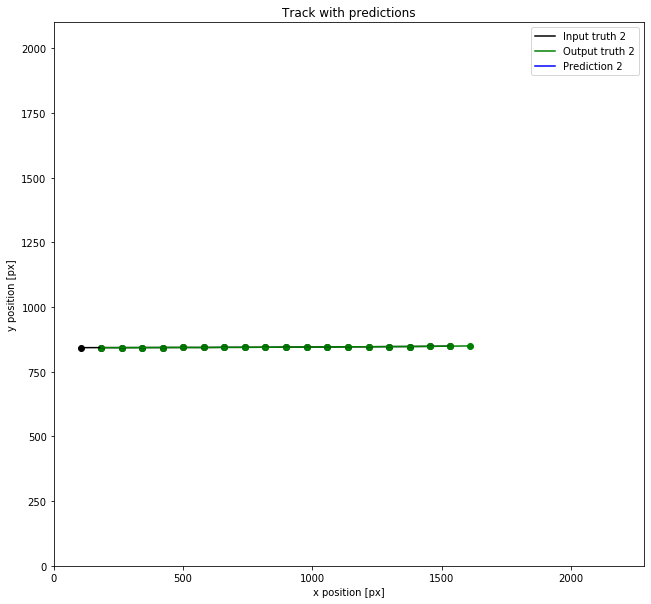

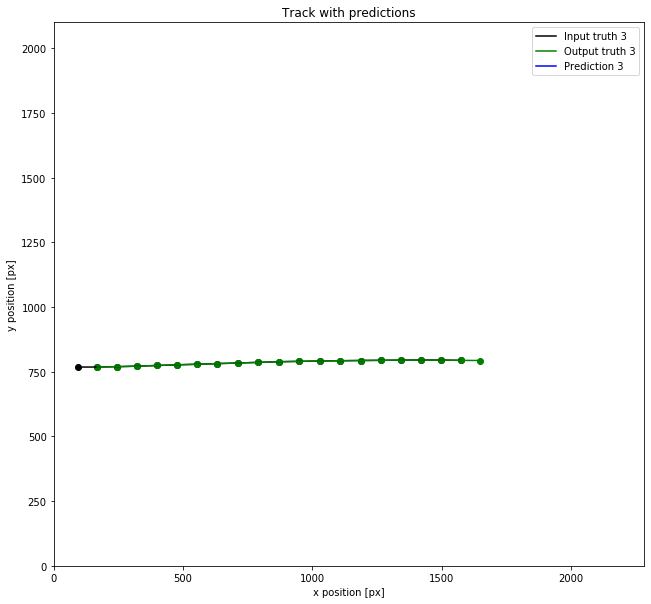

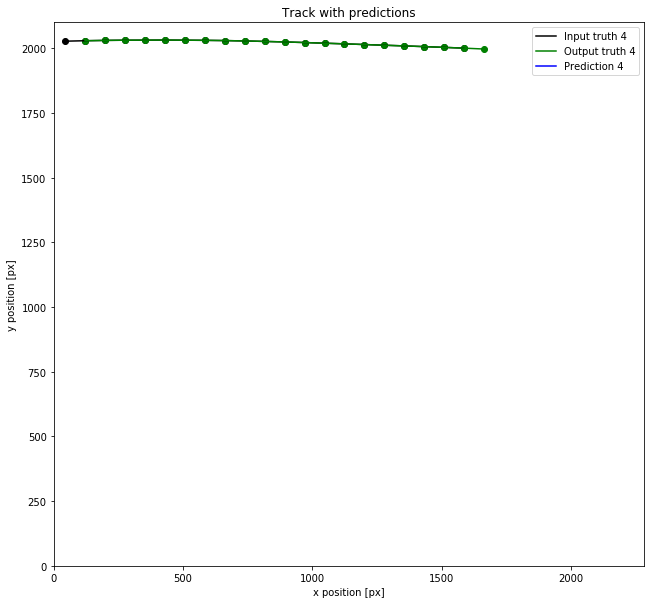

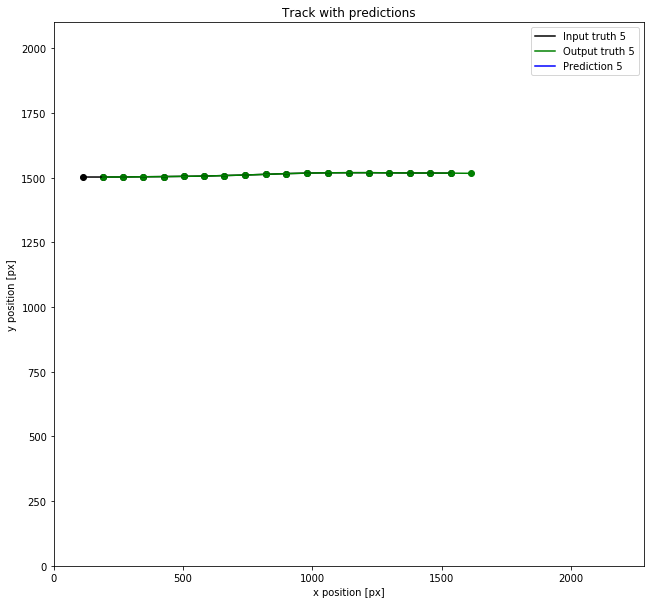

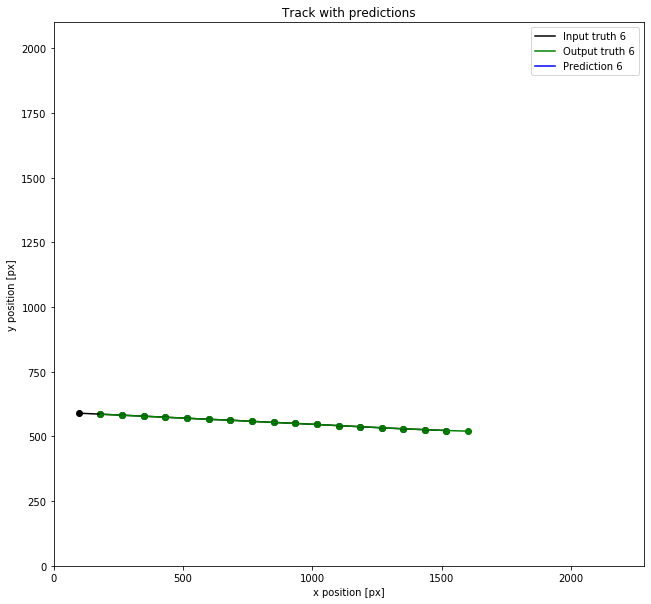

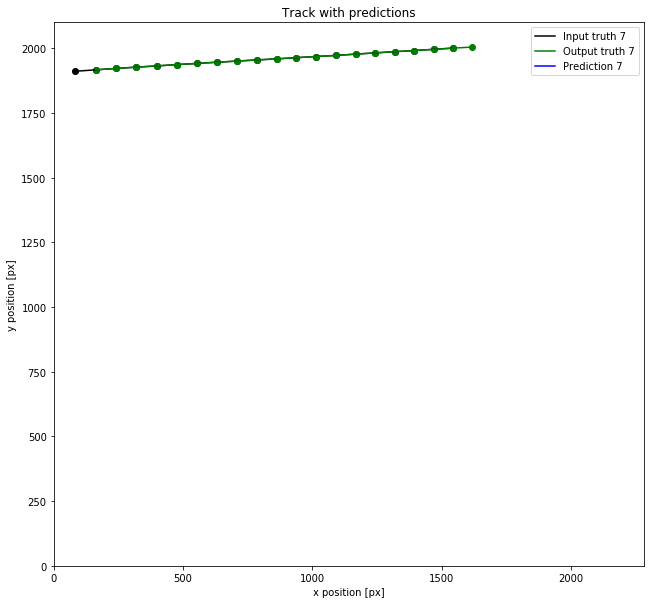

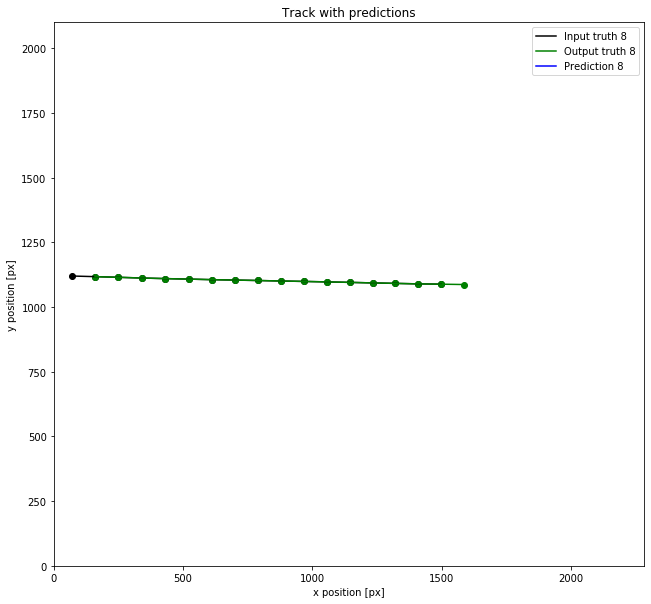

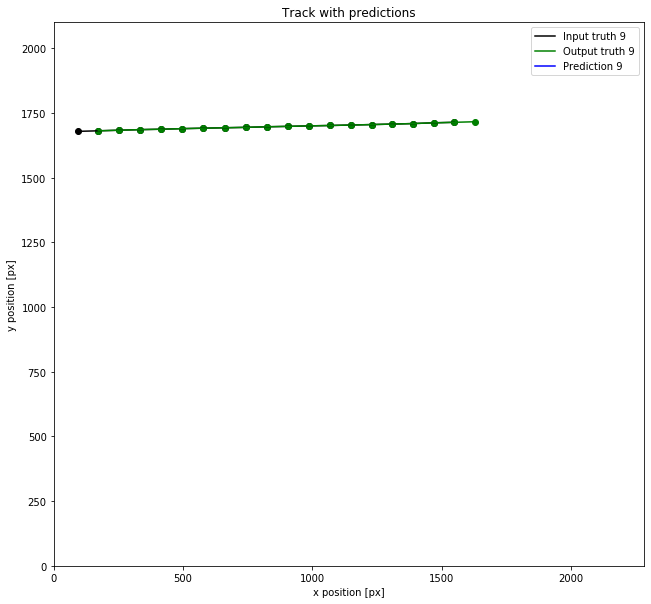

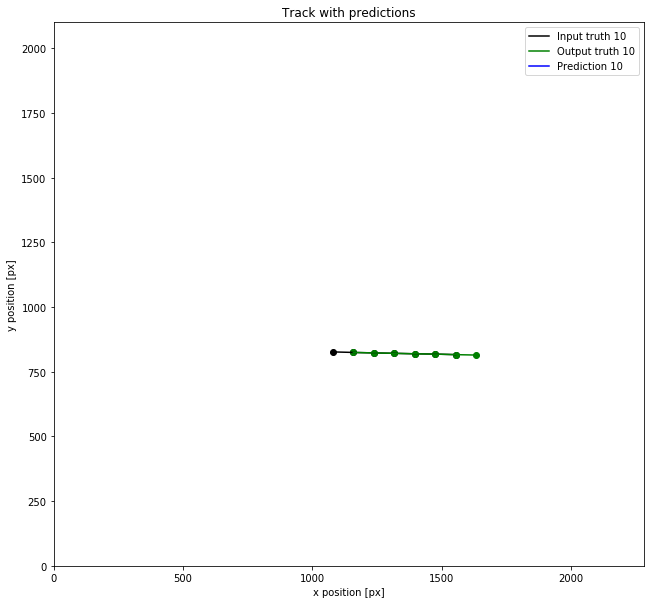

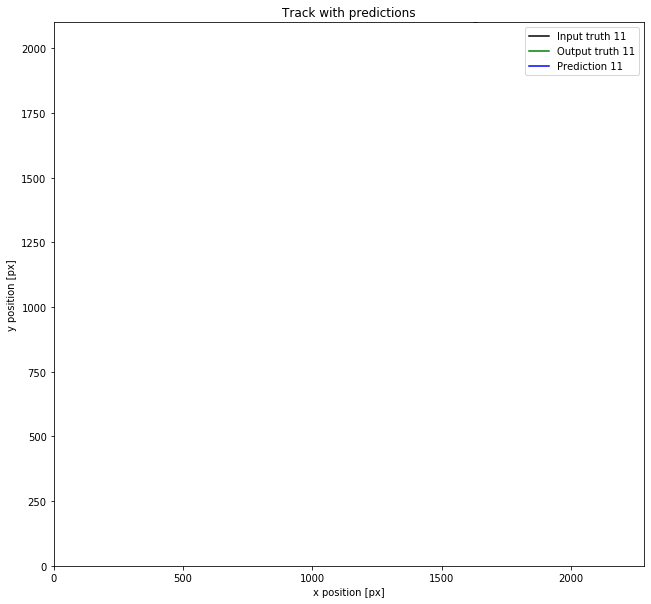

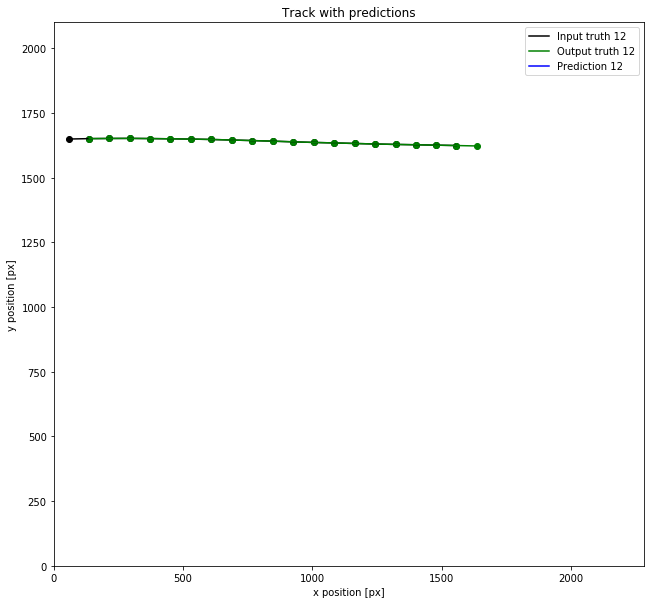

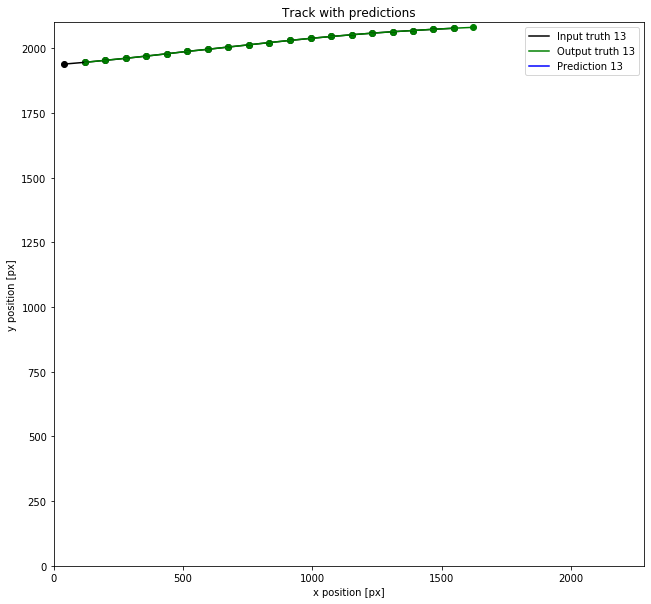

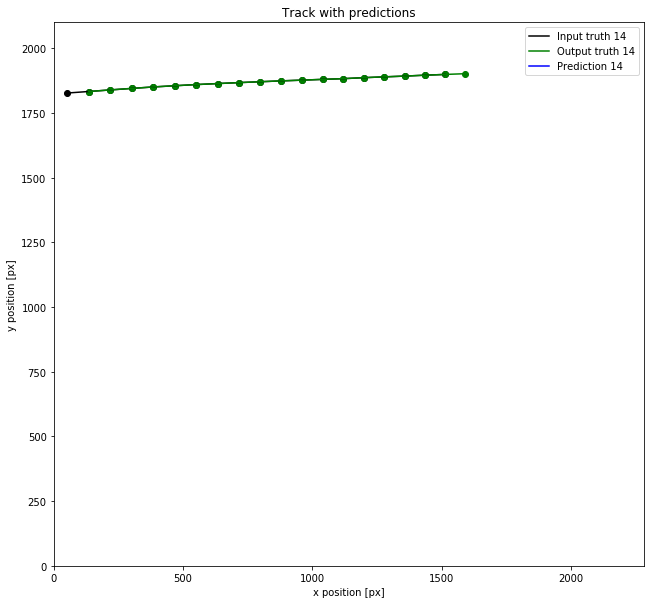

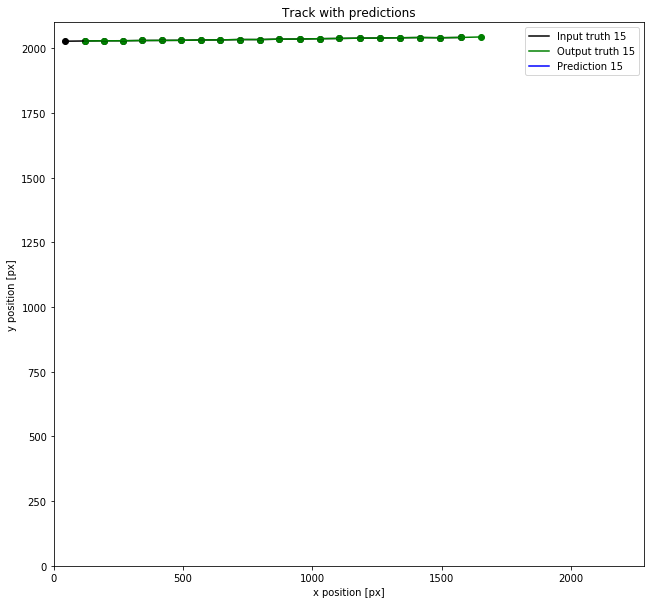

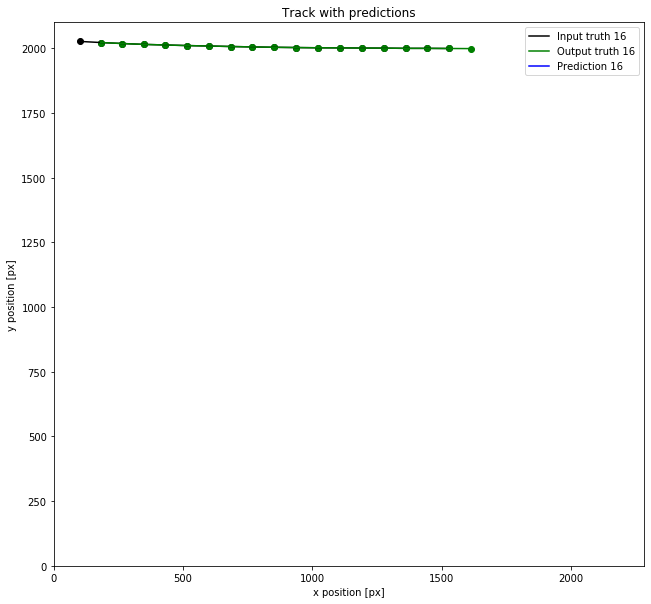

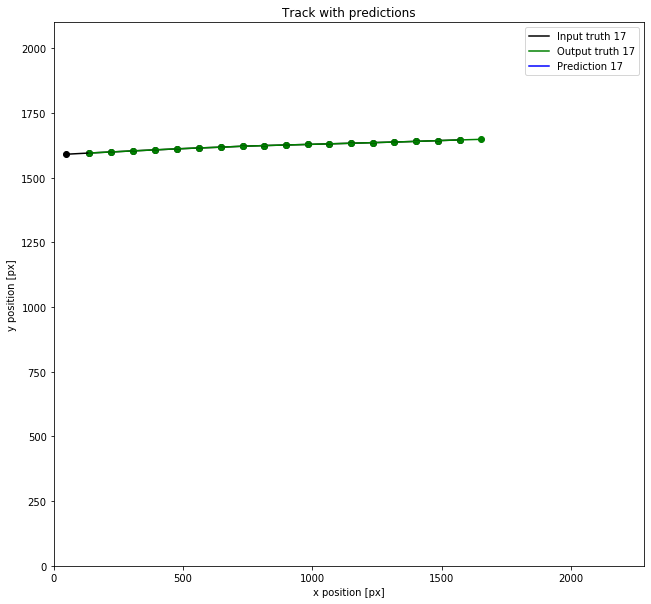

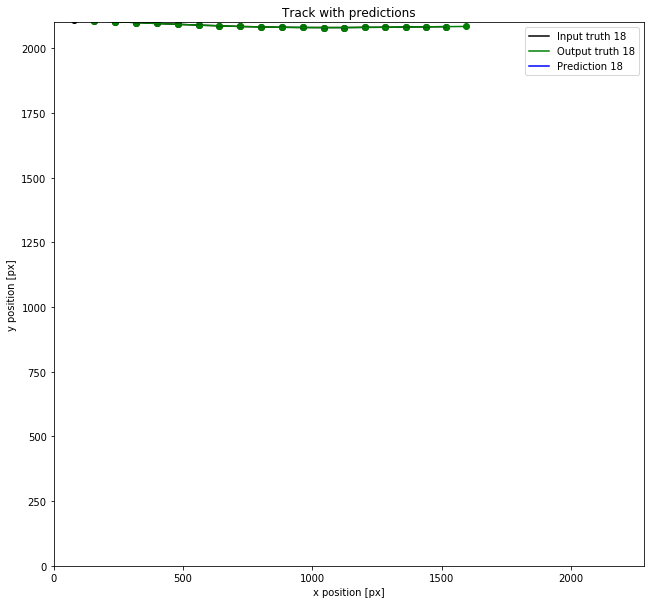

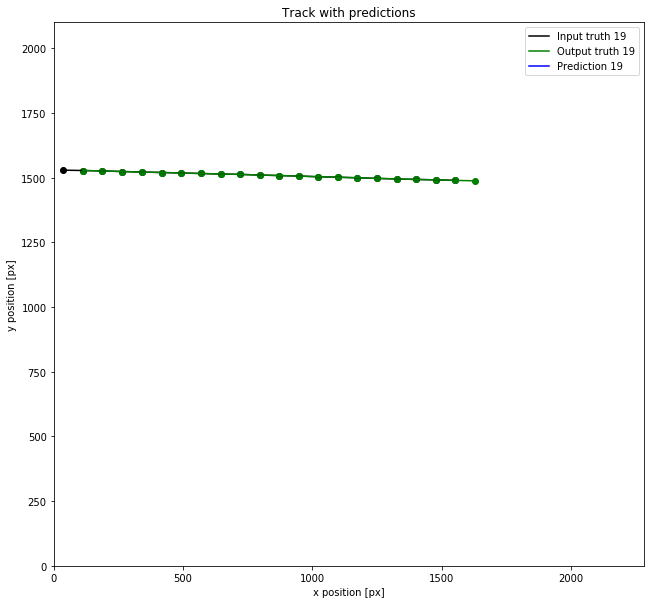

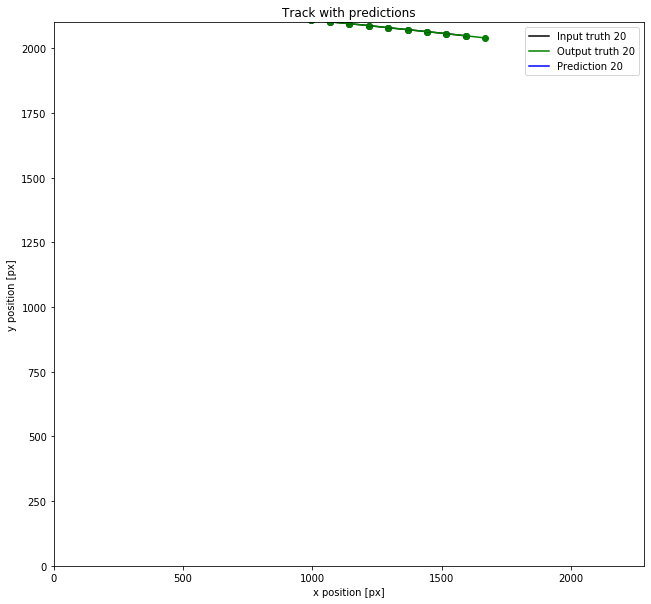

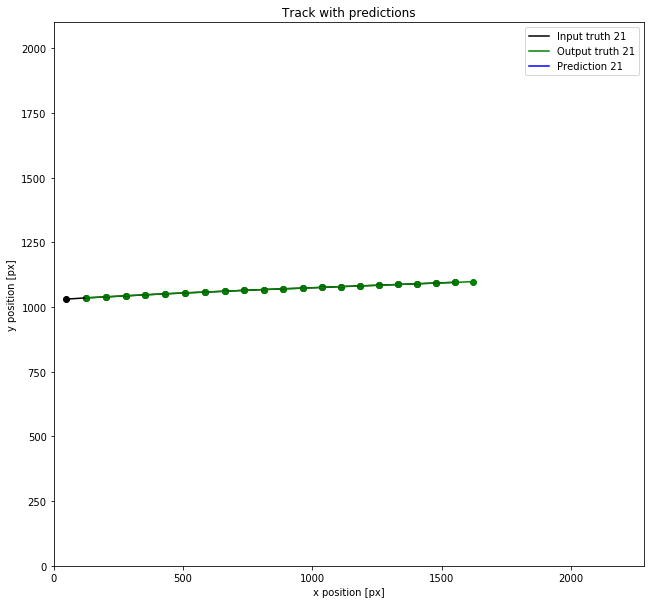

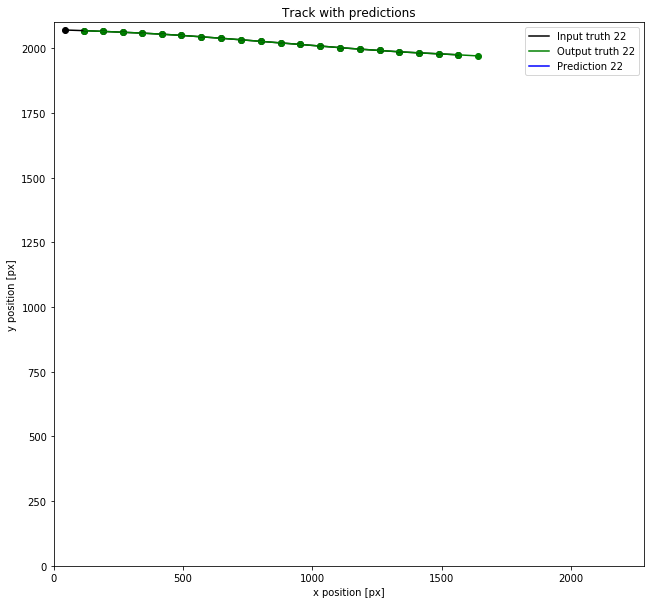

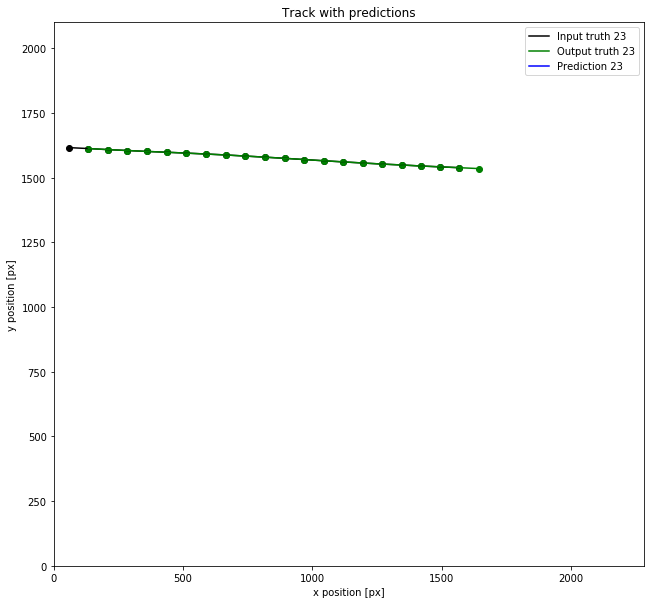

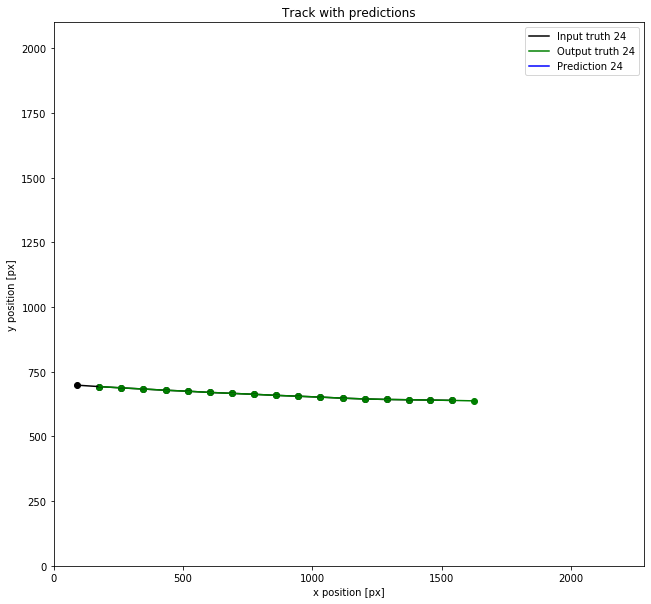

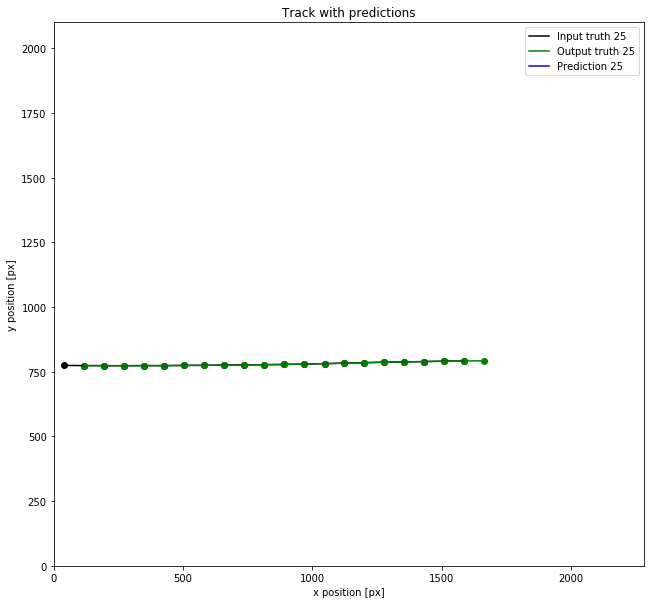

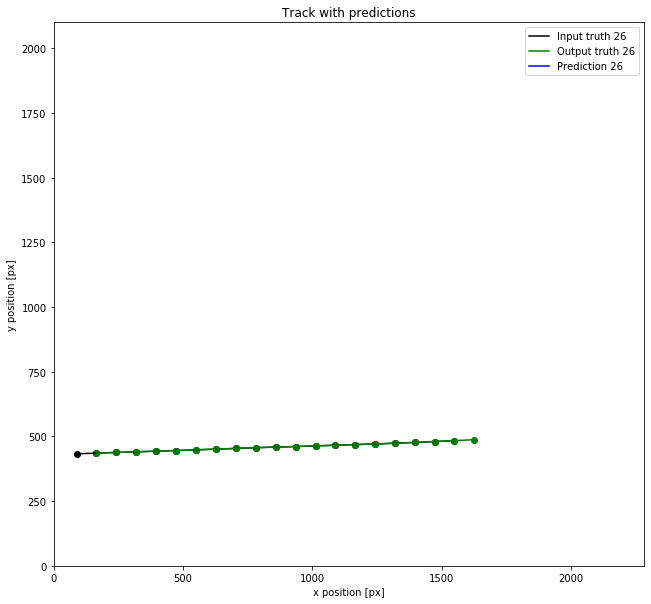

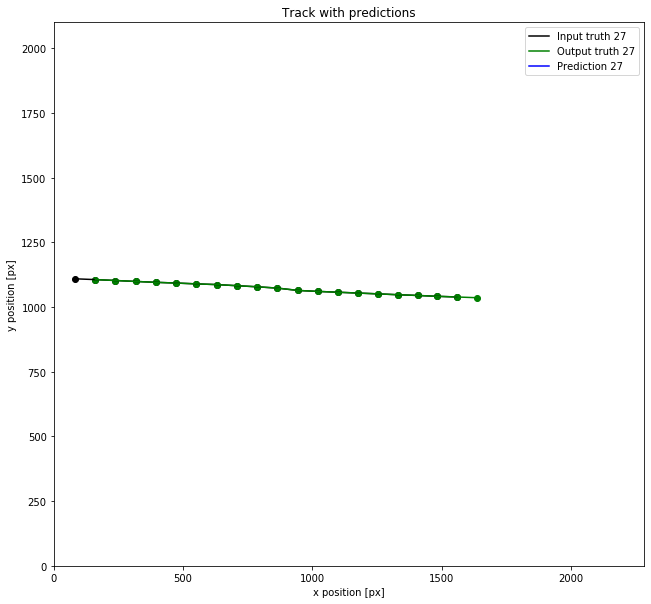

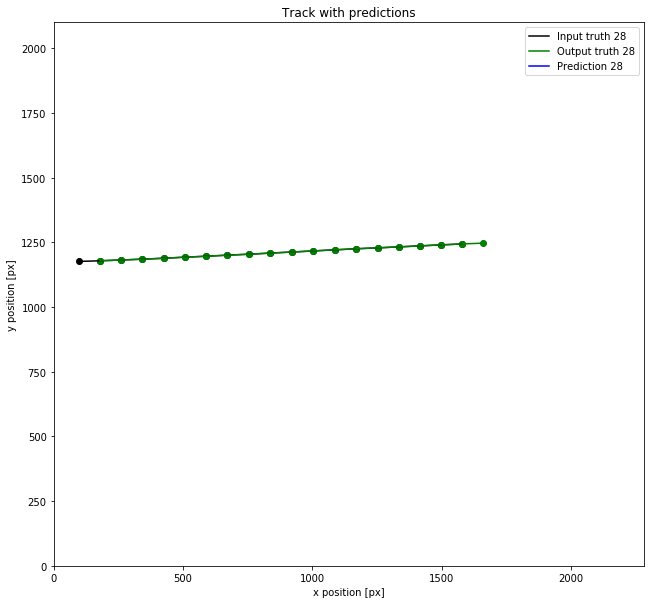

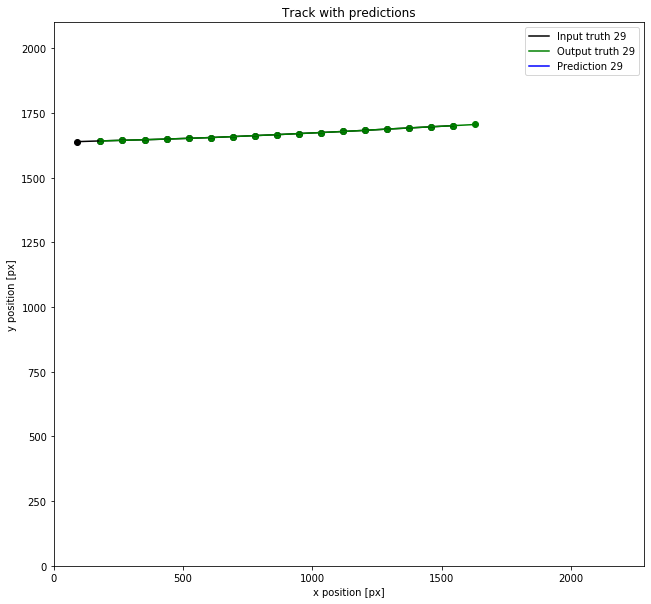

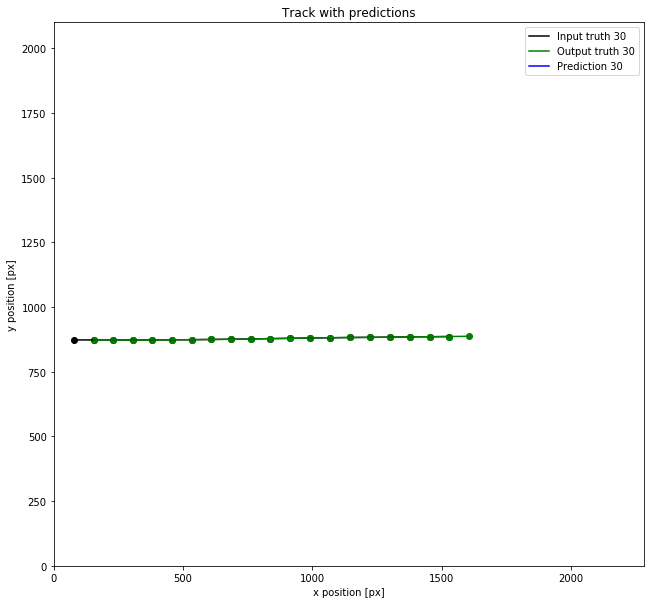

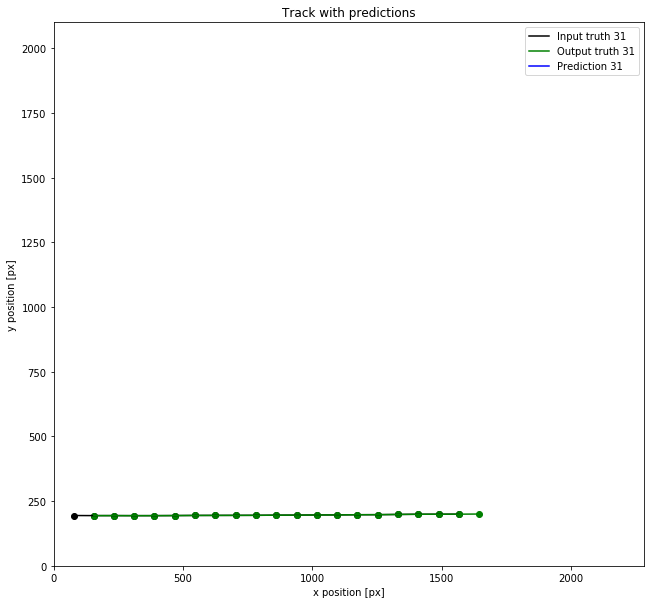

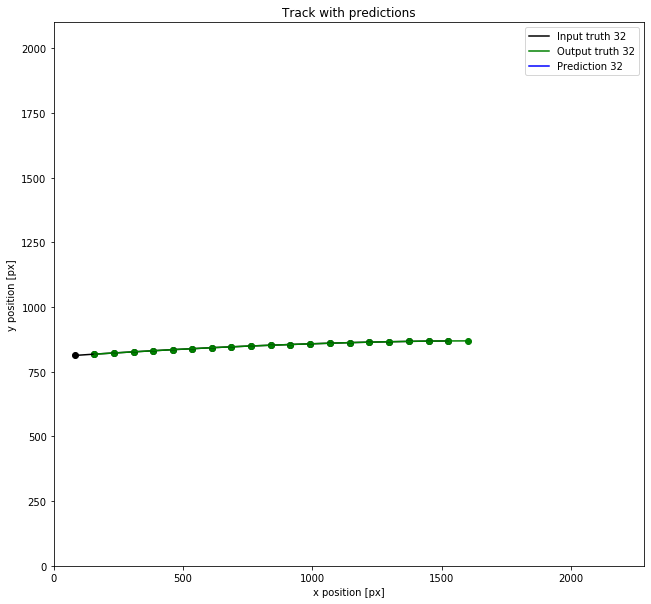

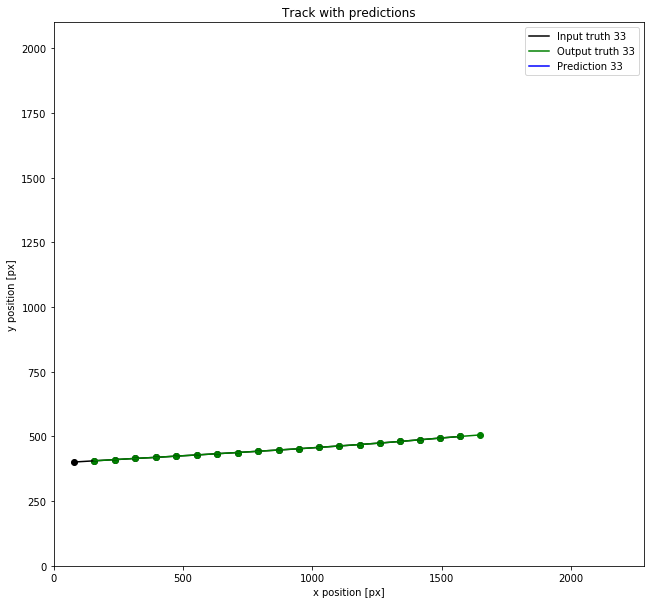

KeyboardInterrupt: 

In [107]:
# for every batch
for (batch_n, (inp_batch, target_batch)) in enumerate(dataset_train.take(1)):
    inp_batch = inp_batch.numpy()
    target_batch = target_batch.numpy()
    prediction_list = []

    _ = rnn_model.reset_states()

    # Calculate the mask
    mask = K.all(K.equal(target_batch, mask_value), axis=-1)
    mask = 1 - K.cast(mask, tf.float32)
    mask = K.cast(mask, tf.float32)

    # for every time step
    for time_i in range(inp_batch.shape[1]):
        with tf.GradientTape() as tape:
            input_ = inp_batch[:, time_i, :].reshape([batch_size, 1, 2])
            target = target_batch[:, time_i, :].reshape([batch_size, 1, 2])
            time_step_mask = tf.reshape(mask[:, time_i], [batch_size, 1])

            if K.sum(time_step_mask) == 0:
                # if no track of the batch has input data, then we continue with the
                #   next batch
                break;

            if time_i == 0:
                prior_error = tf.zeros_like(input_)
                prior_prediction = input_

            concat_input = tf.concat((input_, prior_prediction, prior_error), axis=-1)
            concat_input = tf.reshape(concat_input, [batch_size, 1, 6])

            predic = rnn_model(concat_input)
            prediction_list.append(predic.numpy())

            pos_pred = predic[:, :, :2]
            mse_pred = predic[:, :, 2]

            pos_loss = tf.reduce_sum((csv_data_set.belt_width*(pos_pred - target))**2, axis=-1)  # **0.5
            mse_loss = (csv_data_set.belt_width*(mse_pred - pos_mse)**2)  # **0.5
            sum_loss = time_step_mask * (pos_loss + mse_loss)

            sum_batch_loss += K.sum(sum_loss)
            batch_n_time_steps += K.sum(time_step_mask)

            loss = K.sum(sum_loss) / K.sum(time_step_mask)

            prior_error = pos_pred - target
            prior_prediction = pos_pred

            grads = tape.gradient(loss, rnn_model.trainable_variables)
            optimizer.apply_gradients(zip(grads, rnn_model.trainable_variables))
            
    # plot track
    prediction_list = np.array(prediction_list).reshape([batch_size, -1, 3])
    pos_predictions = prediction_list[:, :, :2]
    var_predictions = prediction_list[:, :, 2]
    
    # denormalize
    input_batch = csv_data_set.denormalize_tracks(inp_batch)
    target_batch = csv_data_set.denormalize_tracks(target_batch)
    batch_predictions = csv_data_set.denormalize_tracks(pos_predictions)
    var_predictions = var_predictions * np.sqrt(csv_data_set.belt_width)

    start_time_step = 0
    fit_scale_to_content = False
    
    print(batch_predictions.shape)

    for track_idx in range(input_batch.shape[0]):
        seq_length = csv_data_set.get_last_timestep_of_track(input_batch[track_idx])

        axes = csv_data_set.plot_track(input_batch[track_idx], start=start_time_step,
                              fit_scale_to_content=fit_scale_to_content,
                              color='black', end=seq_length, label="Input truth {}".format(track_idx))
        axes = csv_data_set.plot_track(target_batch[track_idx], start=start_time_step,
                              fit_scale_to_content=fit_scale_to_content,
                              color='green', end=seq_length, label="Output truth {}".format(track_idx))
        axes = csv_data_set.plot_track(batch_predictions[track_idx], start=start_time_step,
                              fit_scale_to_content=fit_scale_to_content,
                              color='blue', end=seq_length, label="Prediction {}".format(track_idx))

        axes.scatter(batch_predictions[track_idx, :, 0], batch_predictions[track_idx, :, 1], 
                   s=4*var_predictions[track_idx, :], alpha=0.3)

        plt.title('Track with predictions')

        plt.show()


In [85]:
n = 1

for (batch_n, (inp_batch, target_batch)) in enumerate(dataset_train.take(n)):
    inp_batch = inp_batch.numpy()
    target_batch = target_batch.numpy()
    prediction_list = []

    # for every track
    for track_i in range(inp_batch.shape[0]):

      _ = rnn_model.reset_states()

      # for every time step
      for time_i in range(inp_batch.shape[1]):
        input_ = inp_batch[track_i, time_i, :].reshape([1,1,2])
        target = target_batch[track_i, time_i, :].reshape([1,1,2])

        if not input_.any():
          break

        # the first time step has no prior predictions and no prior error
        if time_i == 0:
          prior_error = tf.zeros_like(input_)
          prior_prediction = input_

        concat_input = tf.concat((input_, prior_prediction, prior_error), axis=-1)

        predic = rnn_model(concat_input)
        prediction_list.append(predic.numpy().reshape(1, 3))
        
        # priors for the next step
        prior_error = predic[:,:,:2] - target
        prior_prediction = predic[:,:,:2]
      
    # plot track
    prediction_list = np.array(prediction_list).reshape([1, -1, 3])
    pos_predictions = prediction_list[:, :, :2]
    var_predictions = prediction_list[:, :, 2]
    
    # denormalize
    input_batch = csv_data_set.denormalize_tracks(inp_batch)
    target_batch = csv_data_set.denormalize_tracks(target_batch)
    batch_predictions = csv_data_set.denormalize_tracks(pos_predictions)
    var_predictions = var_predictions * np.sqrt(csv_data_set.belt_width)

    start_time_step = 0
    fit_scale_to_content = False

    for track_idx in range(input_batch.shape[0]):
      seq_length = csv_data_set.get_last_timestep_of_track(input_batch[track_idx])

      axes = csv_data_set.plot_track(input_batch[track_idx], start=start_time_step,
                              fit_scale_to_content=fit_scale_to_content,
                              color='black', end=seq_length, label="Input truth {}".format(track_idx))
      axes = csv_data_set.plot_track(target_batch[track_idx], start=start_time_step,
                              fit_scale_to_content=fit_scale_to_content,
                              color='green', end=seq_length, label="Output truth {}".format(track_idx))
      axes = csv_data_set.plot_track(batch_predictions[track_idx], start=start_time_step,
                              fit_scale_to_content=fit_scale_to_content,
                              color='blue', end=seq_length, label="Prediction {}".format(track_idx))
      
      axes.scatter(batch_predictions[track_idx, :, 0], batch_predictions[track_idx, :, 1], 
                   s=4*var_predictions[track_idx, :], alpha=0.3)
      
      plt.title('Track with predictions')

    plt.show()

    

InvalidArgumentError: Invalid input_h shape: [1,128,64] [1,1,64] [Op:CudnnRNNV3]

In [14]:
maes = []

for (batch_n, (inp_batch, target_batch)) in enumerate(dataset_test):
    if batch_n % 100 == 0:
      print("-", end='')
    inp_batch = inp_batch.numpy()
    target_batch = target_batch.numpy()

    # for every track
    for track_i in range(inp_batch.shape[0]):

      _ = rnn_model.reset_states()
      
      sum_track_mae = 0
      track_steps = 0

      # for every time step
      for time_i in range(inp_batch.shape[1]):
        input_ = inp_batch[track_i, time_i, :].reshape([1,1,2])
        target = target_batch[track_i, time_i, :].reshape([1,1,2])

        if not input_.any():
          break

        # the first time step has no prior predictions and no prior error
        if time_i == 0:
          prior_error = tf.zeros_like(input_)
          prior_prediction = input_

        concat_input = tf.concat((input_, prior_prediction, prior_error), axis=-1)

        predic = rnn_model(concat_input).numpy()[0, 0,:2].reshape([1,1,2])
        
        # priors for the next step
        prior_error = predic - target
        prior_prediction = predic

        mae = np.sqrt(np.sum((csv_data_set.belt_width*(predic - target))**2))

        sum_track_mae += mae
        track_steps += 1
      
      maes.append(sum_track_mae/track_steps)
 
maes = np.array(maes)

-------

{'whiskers': [<matplotlib.lines.Line2D at 0x7f11b0450b70>,
 'caps': [<matplotlib.lines.Line2D at 0x7f11b0329f98>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f11b0450860>],
 'medians': [<matplotlib.lines.Line2D at 0x7f11b0329be0>],
 'fliers': [],
 'means': []}

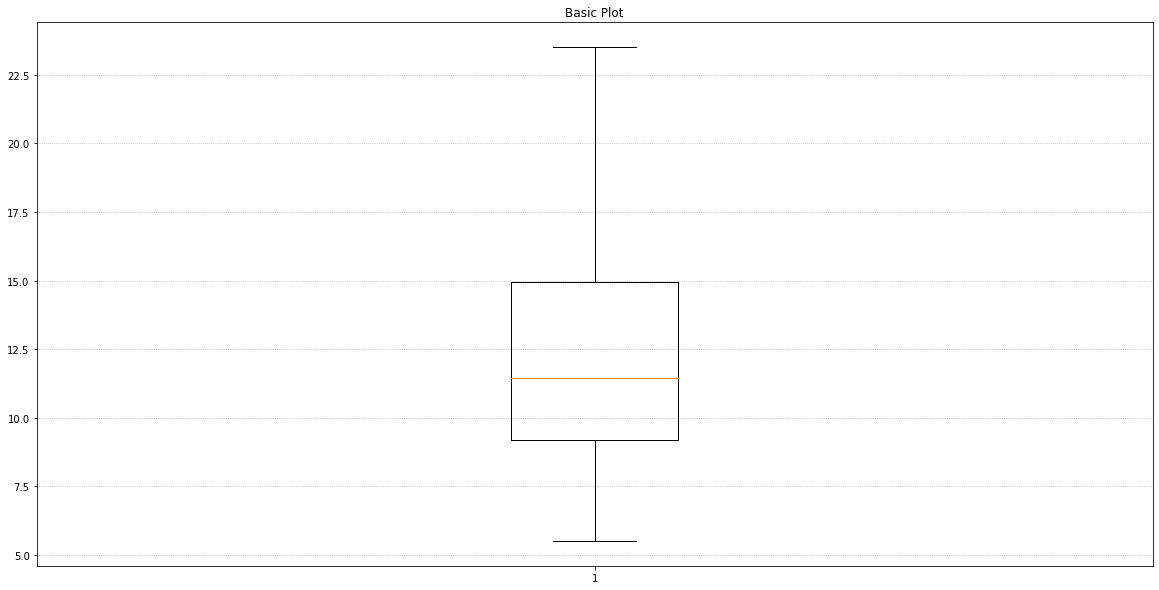

In [15]:
plt.rc('grid', linestyle=":")
fig1, ax1 = plt.subplots()
ax1.yaxis.grid(True)
  
ax1.set_title('Basic Plot')
ax1.boxplot(maes, showfliers=False)